In [1]:
import sys, os



import numpy as np
import argparse
import pickle

from pyeit.mesh import PyEITMesh
import pyeit.mesh as mesh
from pyeit.eit.interp2d import sim2pts
from pyeit.eit.protocol import PyEITProtocol
from pyeit.visual.plot    import create_mesh_plot, create_plot
from pyeit.mesh.shape import *
from pyeit.mesh.utils import edge_list
from pyeit.mesh import PyEITMesh


In [3]:
def load_mesh_pkl(path):
    """
    Load a mesh from a pickle file.
    Parameters
    ----------
    path : str
        Path to the pickle file containing the mesh data.   
    Returns
    -------
    mesh : PyEITMesh
        The loaded mesh object.
    mask : np.ndarray               
        The mask of the mesh.
    boundary_edges : np.ndarray
    """
    with open(path,"rb") as f:
        d = pickle.load(f)
    mesh = PyEITMesh(node=d["node"],
                     element=d["element"],
                     el_pos=d["el_pos"])
    mesh.perm = d["perm"]
    return mesh, d["mask"],d["boundary_edges"],d["present_organs"],d["slice_number"],d["z_min"],d["z_max"]



In [4]:
## Adapt the path to your mesh file
case = "s0029"
slice_number =  0
meshA,maskA,barsA,present_organsA,z,z_min,z_max = load_mesh_pkl(f"scratch/aboulette/meshes_cache_sujets/{case}/{case}_mesh_slice_{slice_number}.pkl")


In [5]:
print(f"torso zone of subject {case} is limited by slice z_min: {z_min}, and  z_max: {z_max}")


torso zone of subject s0029 is limited by slice z_min: 209, and  z_max: 411


In [6]:
print(f"present organs in the mesh: {present_organsA}")

present organs in the mesh: ['adrenal_gland', 'atrial_appendage', 'autochthon', 'aorta', 'brachiocephalic_trunk', 'brachiocephalic_vein', 'clavicula', 'colon', 'common_carotid_artery', 'costal_cartilages', 'duodenum', 'esophagus', 'gallbladder', 'heart', 'humerus', 'iliopsoas', 'inferior_vena_cava', 'kidney', 'lung', 'pancreas', 'pulmonary_vein', 'portal_and_splenic_vein', 'ribs', 'scapula', 'small_bowel', 'spinal_cord', 'spleen', 'sternum', 'stomach', 'subclavian_artery', 'superior_vena_cava', 'thyroid_gland', 'trachea', 'vertebrae', 'liver']


In [7]:
print(f" slice number: {slice_number}")

 slice number: 0


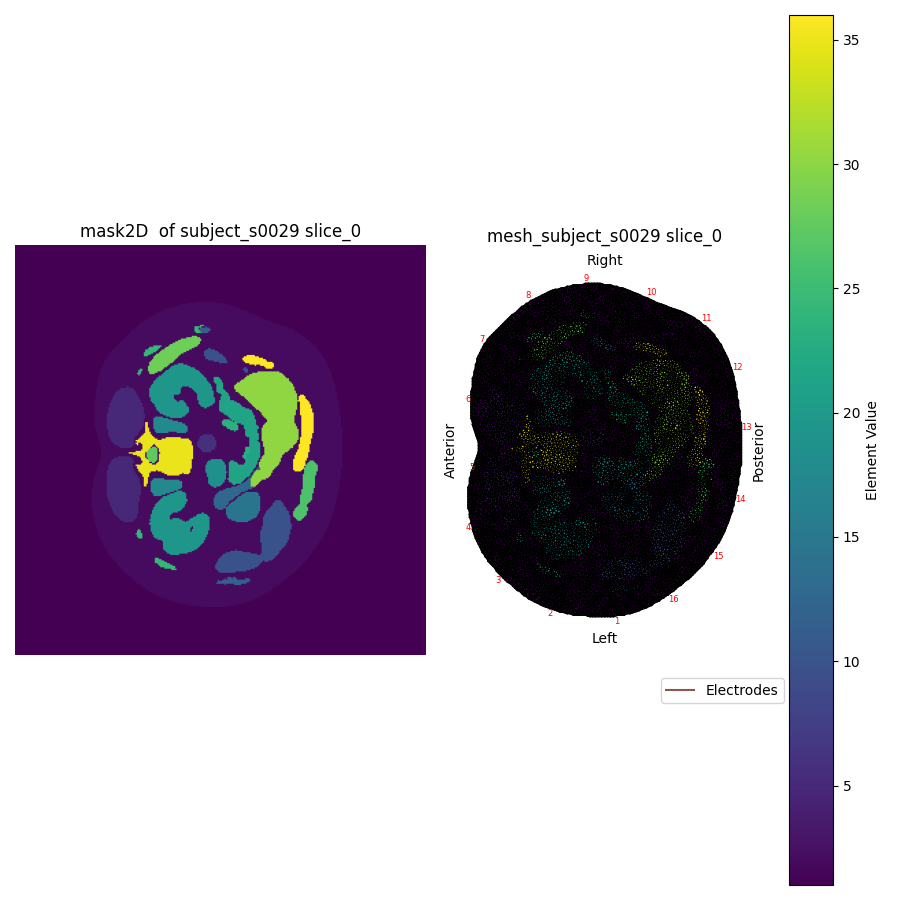

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(9, 9))

ax0.imshow(maskA, cmap='viridis')
ax0.set_title(f"mask2D  of subject_{case} slice_{slice_number}")
ax0.axis("off")
  
create_mesh_plot(
                    ax1,meshA,
                    electrodes=meshA.el_pos,
                    coordinate_labels="radiological",
                    marker_text_kwargs={"color": "red", "fontsize": 6}
)
ax1.set_title(f"mesh_subject_{case} slice_{slice_number}")
ax1.axis("off")

plt.tight_layout()
plt.show()

In [13]:
print(f"boundary edges of the mesh: {barsA}")

boundary edges of the mesh: [[ 20  21]
 [ 29  30]
 [ 36  37]
 [ 49  50]
 [ 60  61]
 [ 87  88]
 [ 65  66]
 [ 70  71]
 [ 85  86]
 [ 84  85]
 [265 266]
 [138 139]
 [100 101]
 [101 102]
 [145 146]
 [144 145]
 [150 151]
 [167 168]
 [182 183]
 [186 187]
 [211 212]
 [204 205]
 [221 222]
 [212 213]
 [196 197]
 [236 237]
 [233 234]
 [137 138]
 [245 246]
 [259 260]
 [274 275]
 [275 276]
 [  0   1]
 [298 299]
 [295 296]
 [301 302]
 [297 298]
 [308 309]
 [332 333]
 [323 324]
 [327 328]
 [321 322]
 [324 325]
 [ 54  55]
 [246 247]
 [189 190]
 [ 39  40]
 [304 305]
 [ 22  23]
 [ 23  24]
 [ 64  65]
 [166 167]
 [289 290]
 [177 178]
 [251 252]
 [  7   8]
 [148 149]
 [ 17  18]
 [200 201]
 [ 11  12]
 [294 295]
 [119 120]
 [208 209]
 [ 19  20]
 [330 331]
 [191 192]
 [ 14  15]
 [ 15  16]
 [ 97  98]
 [103 104]
 [102 103]
 [134 135]
 [ 52  53]
 [152 153]
 [216 217]
 [183 184]
 [117 118]
 [288 289]
 [ 31  32]
 [ 43  44]
 [  2   3]
 [ 28  29]
 [252 253]
 [ 69  70]
 [164 165]
 [ 86  87]
 [309 310]
 [203 204]
 [31

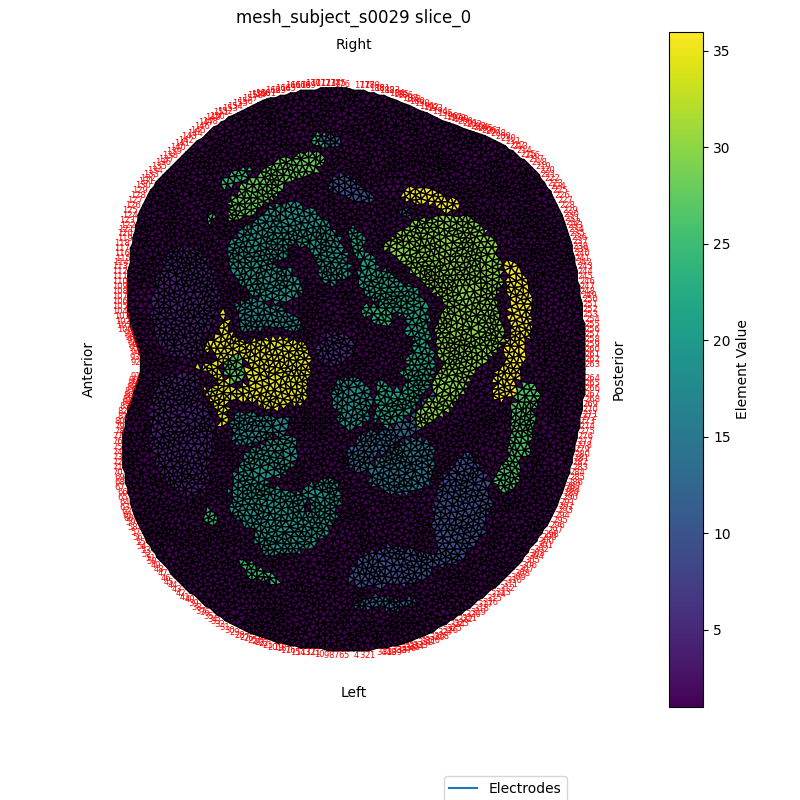

In [9]:
%matplotlib widget

fig, ax0 = plt.subplots(1, 1, figsize=(8,8))



create_mesh_plot(
                    ax0,meshA,
                    electrodes=np.arange(len(barsA)),
                    coordinate_labels="radiological",
                    marker_text_kwargs={"color": "red", "fontsize": 6}
)
ax0.set_title(f"mesh_subject_{case} slice_{slice_number}")
ax0.axis("off")

plt.tight_layout()
plt.show()

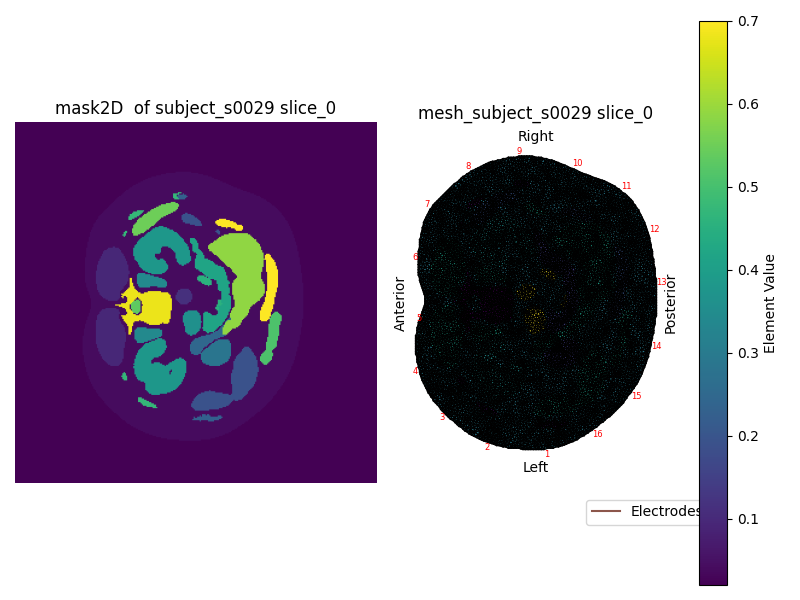

In [10]:
def sig_update(org_list, sig):

    # conductivity lookup
    cond_table = {
        'soft_tissue': 0.30,
        'adrenal_gland': 0.25,
        'autochthon': 0.40,
        'clavicula': 0.02,
        'costal_cartilages': 0.08,
        'ribs': 0.05,
        'scapula': 0.02,
        'sternum': 0.02,
        'skull': 0.02,
        'humerus': 0.02,
        'femur': 0.02,
        'vertebrae': 0.02,
        'sacrum': 0.02,
        'gluteus_maximus': 0.40,
        'gluteus_minimus': 0.40,
        'gluteus_medius': 0.40,
        'iliopsoas': 0.40,
        'hip': 0.08,
        'iliac_arterie': 0.70,
        'iliac_vein': 0.70,
        'brachiocephalic_trunk': 0.70,
        'brachiocephalic_vein': 0.70,
        'common_carotid_artery': 0.70,
        'subclavian_artery': 0.70,
        'aorta': 0.70,
        'superior_vena_cava': 0.70,
        'inferior_vena_cava': 0.70,
        'portal_and_splenic_vein': 0.70,
        'pulmonary_vein': 0.70,
        'trachea': 0.15,
        'lung': 0.15,
        'heart': 0.50,
        'atrial_appendage': 0.20,
        'esophagus': 0.40,
        'stomach': 0.40,
        'duodenum': 0.40,
        'small_bowel': 0.40,
        'colon': 0.40,
        'liver': 0.20,
        'gallbladder': 0.15,
        'pancreas': 0.15,
        'spleen': 0.20,
        'thyroid_gland': 0.50,
        'kidney': 0.35,
        'kidney_cyst': 1.50,
        'urinary_bladder': 1.50,
        'prostate': 0.35,
        'spinal_cord': 0.30,
    }

    # build master list
    master_names = ['soft_tissue'] + list(org_list)

    master_values = []
    for name in master_names:
        if name not in cond_table:
            raise ValueError(f"No conductivity defined for '{name}'")
        master_values.append(cond_table[name])
    master_values = np.array(master_values)

    # --- Adjust labels (1-based → 0-based) ---
    sig_idx = np.asarray(sig, dtype=int) - 1  

    # check for out-of-range
    if sig_idx.max() >= len(master_values) or sig_idx.min() < 0:
        raise IndexError("Some labels in 'sig' exceed available mapping")

    sigma_real = master_values[sig_idx]

    return sigma_real

sig_real = sig_update(present_organsA, meshA.perm)
meshA.perm =sig_real

%matplotlib widget

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 6))

ax0.imshow(maskA, cmap='viridis')
ax0.set_title(f"mask2D  of subject_{case} slice_{slice_number}")
ax0.axis("off")
  
create_mesh_plot(
                    ax1,meshA,
                    electrodes=meshA.el_pos,
                    coordinate_labels="radiological",
                    marker_text_kwargs={"color": "red", "fontsize": 6}
)
ax1.set_title(f"mesh_subject_{case} slice_{slice_number}")
ax1.axis("off")

plt.tight_layout()
plt.show()
